In [1]:
%reset -f

# Part 1: Initial Setup and Parsing the LAS File


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Path to your LAS file
file_path = './422393367200_WRA-1009_CXD_SEMB.las'

# Lists to hold the depth and log data (multiple logs)
depths = []
log_data = []

# Reading the LAS file manually
data_section = False  # To identify the start of the data section

with open(file_path, 'r') as las_file:
    for line in las_file:
        line = line.strip()  # Remove any leading/trailing whitespace

        # Look for the start of the data section (~A is the standard in LAS files)
        if line.startswith("~A"):
            data_section = True
            continue  # Skip the "~A" line itself

        # If we're in the data section, process the data
        if data_section:
            # Split the data line into components (assuming space-separated values)
            parts = line.split()
            if len(parts) >= 2:  # Ensure there are enough columns
                try:
                    # Convert the first column to depth and the rest to log data
                    depth = float(parts[0])
                    logs = [float(value) for value in parts[1:]]  # Store remaining columns as logs
                    # Only add valid data (exclude -9999 values)
                    if depth != -9999 and all(val != -9999 for val in logs):
                        depths.append(depth)
                        log_data.append(logs)
                except ValueError:
                    # Handle any lines that don't contain valid data
                    continue

# Convert to numpy arrays
depths = np.array(depths, dtype="float32")

# Convert depth from feet to meters (1 foot = 0.3048 meters)
depths = depths * 0.3048

log_data = np.array(log_data, dtype="float32")




In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define the formation tops in meters
formations = [
    {"name": "Greta", "top": 5084.82 * 0.3048},
    {"name": "Greta Base", "top": 5239.32 * 0.3048},
    {"name": "Glasscock", "top": 5465.68 * 0.3048},
    {"name": "Glasscock Base", "top": 5521.79 * 0.3048},
    {"name": "Ward", "top": 5646.74 * 0.3048},
    {"name": "Ward Base", "top": 5694.34 * 0.3048},
    {"name": "41 - A", "top": 5711.09 * 0.3048},
    {"name": "41 - A Base", "top": 5809.12 * 0.3048},
    {"name": "98 - A", "top": 6140.09 * 0.3048},
    {"name": "98 - A Base", "top": 6270.3 * 0.3048}
]

# Part 2: Visualizing All Log Data

## Density Log

In [4]:
# Example: Choose which log parameter to plot (e.g., log index 1 for the second parameter)
log_DEN = log_data[:, 3]  # Customize this based on your parameter names and number of column
log_DTC = log_data[:, 5]  # Customize this based on your parameter names


## Neutron Porosity Log

## Gamma Ray Log

No handles with labels found to put in legend.


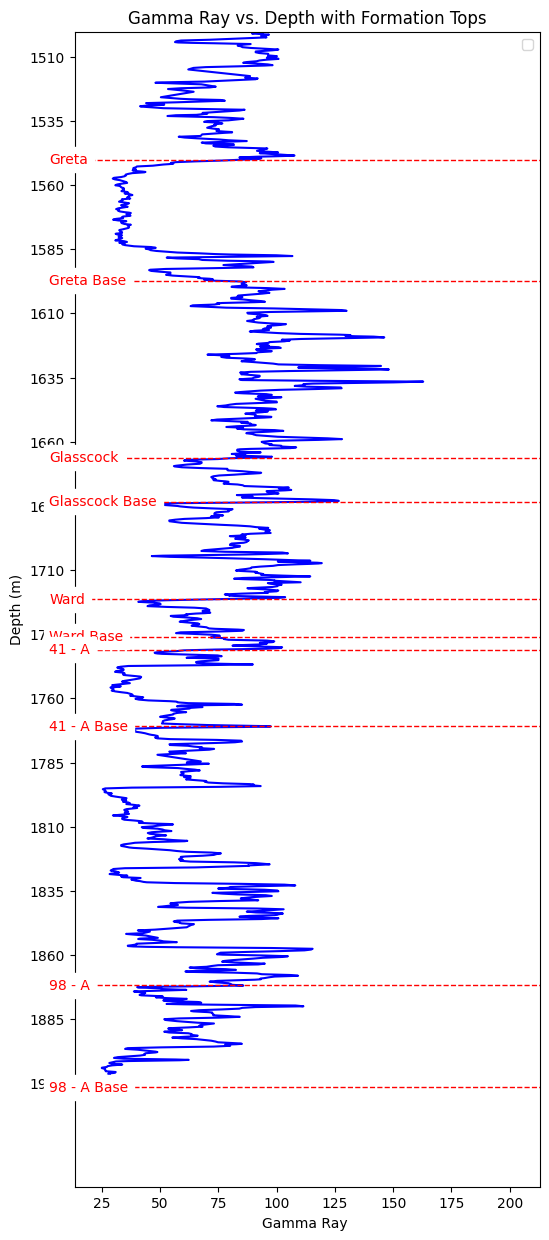

In [5]:
# Example: Choose which log parameter to plot (e.g., log index 1 for the second parameter)
log_GRGC = log_data[:, 11] # Customize this based on your parameter names

# Plotting the selected log against depth
plt.figure(figsize=(6, 15))
plt.plot(log_GRGC, depths, color='blue')
plt.gca().invert_yaxis()  # Invert depth axis

# Set x-axis range based on the selected parameter

# Set y-axis range for depth
plt.ylim(1910, 1500)

# Mark formation tops with labels
for formation in formations:
    plt.axhline(y=formation['top'], color='red', linestyle='--', linewidth=1)
    plt.text(2.5, formation['top'], formation['name'], 
             va='center', ha='left', fontsize=10, color='red', backgroundcolor='white')

# Set depth ticks for y-axis
depth_min, depth_max = np.min(depths), np.max(depths)
depth_interval = 25  # Adjust the interval for depth ticks as needed
plt.yticks(np.arange(depth_min, depth_max + depth_interval, depth_interval))

# Labels and title
plt.xlabel('Gamma Ray ')
plt.ylabel('Depth (m)')

plt.ylim(1950, 1500)

plt.title(f'Gamma Ray vs. Depth with Formation Tops')
plt.legend()
plt.show()


## Vp log

In [6]:
import numpy as np
import pandas as pd

# Define matrix and fluid densities
rho_matrix = 2.65* 1000  # For sandstone, for example
rho_fluid = 0.69* 1000      # For water, assuming the formation contains water

# Assuming log_DEN is your bulk density log
bulk_density = log_DEN* 1000  # Replace with the actual column from your data

# Calculate porosity from density
porosity_density = (rho_matrix - bulk_density) / (rho_matrix - rho_fluid)

In [7]:
# Define your depth range (in meters) for which you want to find the min and max values
depth_min_range = 1665.939264  # Adjust this value based on your range
depth_max_range = 1683.041592  # Adjust this value based on your range

# Filter the data to include only values within the specified depth range
depth_filter = (depths >= depth_min_range) & (depths <= depth_max_range)
log_GRGC_filtered = log_GRGC[depth_filter]

# Compute the min and max of the filtered gamma-ray values
GR_min_range = np.min(log_GRGC_filtered)
GR_max_range = np.max(log_GRGC_filtered)

# Print the results
print(f"Gamma Ray Min (in range {depth_min_range}m - {depth_max_range}m): {GR_min_range}")
print(f"Gamma Ray Max (in range {depth_min_range}m - {depth_max_range}m): {GR_max_range}")

Gamma Ray Min (in range 1665.939264m - 1683.041592m): 55.91680145263672
Gamma Ray Max (in range 1665.939264m - 1683.041592m): 126.69599914550781


In [8]:
# Example data (adjust according to your log data)
log_GRGC = log_data[:, 11]  # Gamma Ray log (log_GRGC)
log_porosity_total = porosity_density  # Replace X with the column index of porosity_density
GR_min = 55.91680145263672  # Gamma Ray value for clean sandstone
GR_max = 126.69599914550781  # Gamma Ray value for pure shale

# 1. Calculate Gamma Ray Index (GRI)
I_GR = (log_GRGC - GR_min) / (GR_max - GR_min)

# 2. Calculate Volume of Shale (Vsh) for compacted formations (use the more complex formula)
Vsh = 0.083 * (2**(3.7 * I_GR) - 1)
# Ensure Vsh does not exceed 1 or drop below 0 (to account for outliers in the gamma-ray log)
Vsh = np.clip(Vsh, 0, 1)

# 3. Calculate Effective Porosity
# Effective porosity = Total porosity * (1 - Vsh)
# porosity_eff = log_porosity_total * (1 - Vsh)
# porosity_eff = log_porosity_total - Vsh * 0.1667

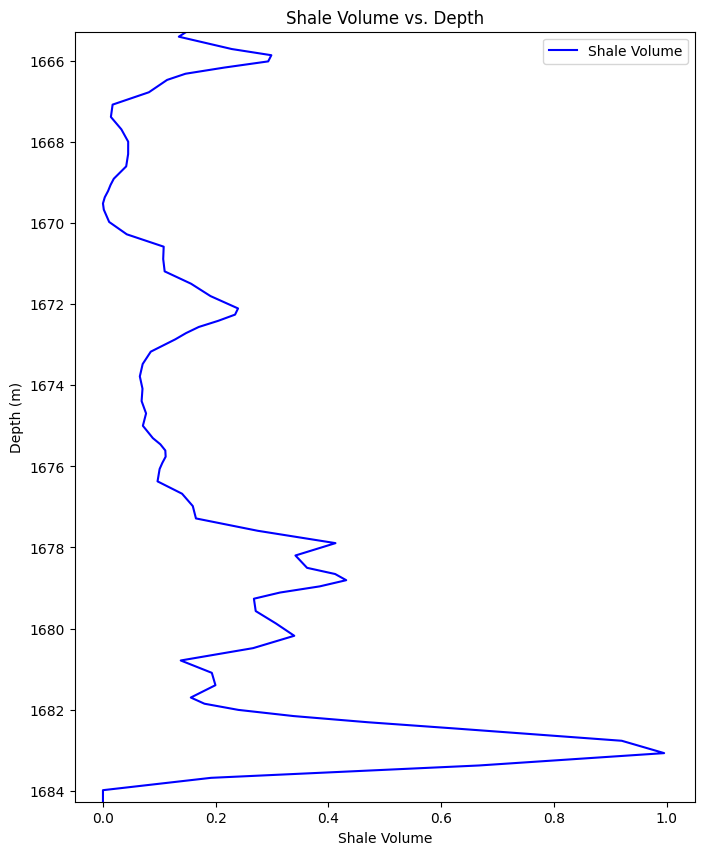

In [9]:
# Plotting the selected log against depth
plt.figure(figsize=(8, 10))


plt.plot(Vsh, depths, color='blue', label='Shale Volume')


plt.gca().invert_yaxis()  # Invert depth axis

# Set x-axis range based on the selected parameter

# Set y-axis range for depth

# Mark formation tops with labels

# Set depth ticks for y-axis
depth_min, depth_max = np.min(depths), np.max(depths)
depth_interval = 2  # Adjust the interval for depth ticks as needed
plt.yticks(np.arange(depth_min, depth_max + depth_interval, depth_interval))


# Labels and title
plt.xlabel('Shale Volume')
plt.ylabel('Depth (m)')

plt.ylim(1684, 1665)

plt.title('Shale Volume vs. Depth')
plt.legend()
plt.show()

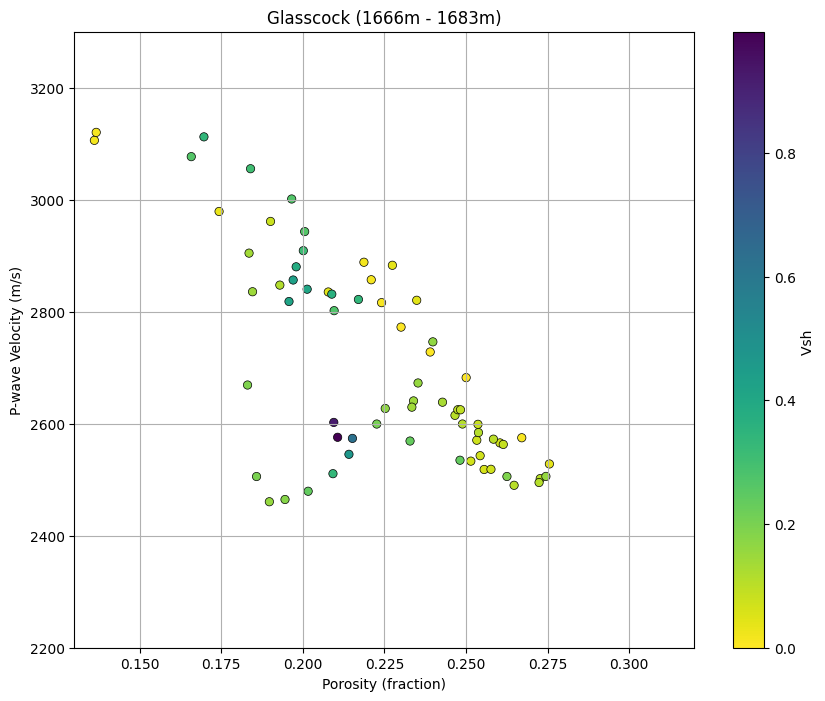

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Set the depth range
a1 = 1665.93926  # lower depth limit
b1 = 1683.04159  # upper depth limit

# Create a mask for the depth range
mask = (depths >= a1) & (depths <= b1)

# Plotting only the data within the specified depth range
plt.figure(figsize=(10, 8))
# Using the 'plasma' colormap
sc = plt.scatter(porosity_density[mask], 1e6 * 0.3048 / log_DTC[mask], c=Vsh[mask], cmap='viridis_r', alpha=1, edgecolor='k', linewidth=0.5)
# sc = plt.scatter(porosity_density[mask], 1e6 * 0.3048 / log_DTC[mask], c=Vsh[mask], cmap='seismic', alpha=0.75, edgecolor='k', linewidth=0.5)

plt.xlabel('Porosity (fraction)')
plt.ylabel('P-wave Velocity (m/s)')

plt.xlim(0.13, 0.32)
plt.ylim(2200, 3300)



plt.title('Glasscock (1666m - 1683m)'.format(a1, b1))
cbar = plt.colorbar(sc)
cbar.set_label('Vsh ')
plt.grid(True)
plt.show()


In [11]:

# ## approach for sampling by interpolation

# import numpy as np
# import matplotlib.pyplot as plt

# # Set the depth range
# a1 = 1665.93926  # lower depth limit
# b1 = 1683.04159  # upper depth limit

# # Create a mask for the depth range
# mask = (depths >= a1) & (depths <= b1)

# # Interpolation to increase the number of sampling points
# depths_interpolated = np.linspace(a1, b1, 200)  # 500 points between a1 and b1
# porosity_density_interpolated = np.interp(depths_interpolated, depths[mask], porosity_density[mask])
# log_DTC_interpolated = np.interp(depths_interpolated, depths[mask], log_DTC[mask])
# Vsh_interpolated = np.interp(depths_interpolated, depths[mask], Vsh[mask])

# # Plotting the interpolated data
# plt.figure(figsize=(10, 8))
# # Using the 'viridis' colormap
# sc = plt.scatter(porosity_density_interpolated, 1e6 * 0.3048 / log_DTC_interpolated, c=Vsh_interpolated, cmap='viridis_r', alpha=0.75, edgecolor='k', linewidth=0.5)

# plt.xlabel('Porosity (fraction)')
# plt.ylabel('P-wave Velocity (m/s)')
# plt.title('CrossPlot of Vp vs Porosity (Colored by Vsh from 0 to 1)')
# cbar = plt.colorbar(sc)
# cbar.set_label('Vsh ')
# plt.grid(True)
# plt.show()


## extend the range

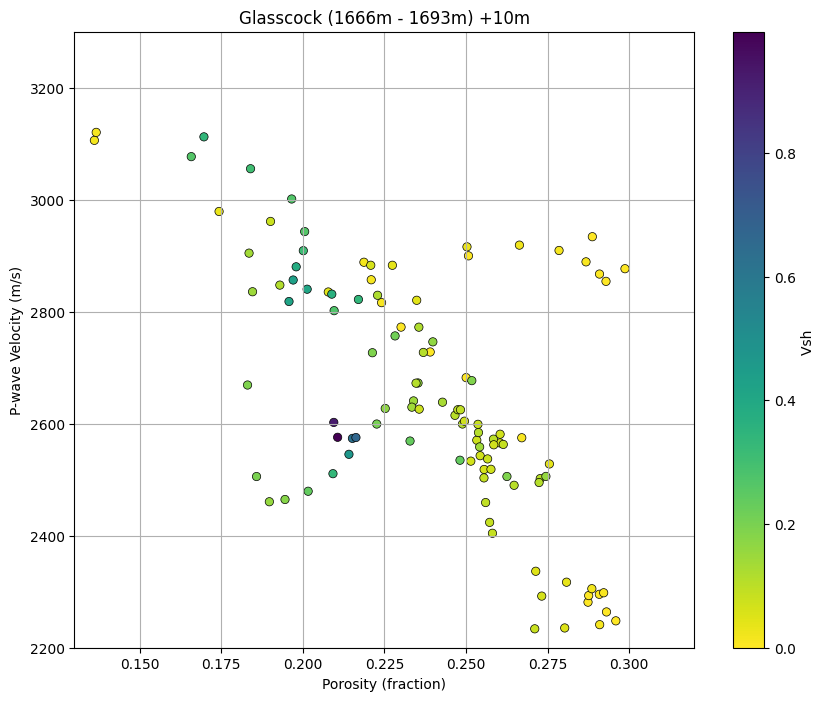

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Set the depth range
a1 = 1665.93926  # lower depth limit
b1 = 1693.04159  # upper depth limit

# Create a mask for the depth range
mask = (depths >= a1) & (depths <= b1)

# Plotting only the data within the specified depth range
plt.figure(figsize=(10, 8))
# Using the 'plasma' colormap
sc = plt.scatter(porosity_density[mask], 1e6 * 0.3048 / log_DTC[mask], c=Vsh[mask], cmap='viridis_r', alpha=1, edgecolor='k', linewidth=0.5)
# sc = plt.scatter(porosity_density[mask], 1e6 * 0.3048 / log_DTC[mask], c=Vsh[mask], cmap='seismic', alpha=0.75, edgecolor='k', linewidth=0.5)

plt.xlabel('Porosity (fraction)')
plt.ylabel('P-wave Velocity (m/s)')

plt.xlim(0.13, 0.32)
plt.ylim(2200, 3300)


plt.title('Glasscock (1666m - 1693m) +10m'.format(a1, b1))
cbar = plt.colorbar(sc)
cbar.set_label('Vsh ')
plt.grid(True)
plt.show()


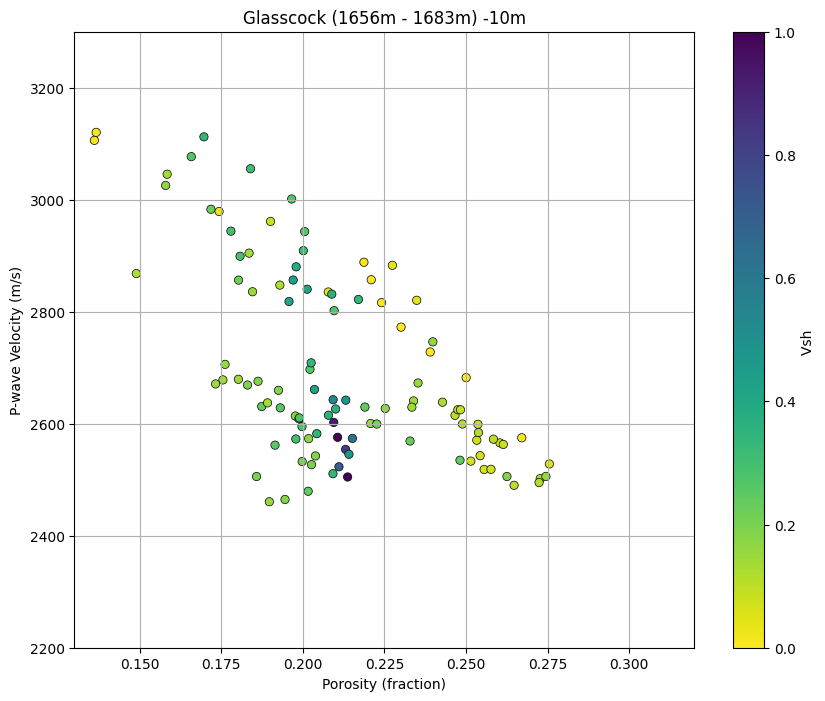

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Set the depth range
a1 = 1655.93926  # lower depth limit
b1 = 1683.04159  # upper depth limit

# Create a mask for the depth range
mask = (depths >= a1) & (depths <= b1)

# Plotting only the data within the specified depth range
plt.figure(figsize=(10, 8))
# Using the 'plasma' colormap
sc = plt.scatter(porosity_density[mask], 1e6 * 0.3048 / log_DTC[mask], c=Vsh[mask], cmap='viridis_r', alpha=1, edgecolor='k', linewidth=0.5)
# sc = plt.scatter(porosity_density[mask], 1e6 * 0.3048 / log_DTC[mask], c=Vsh[mask], cmap='seismic', alpha=0.75, edgecolor='k', linewidth=0.5)

plt.xlabel('Porosity (fraction)')
plt.ylabel('P-wave Velocity (m/s)')

plt.xlim(0.13, 0.32)
plt.ylim(2200, 3300)


plt.title('Glasscock (1656m - 1683m) -10m'.format(a1, b1))
cbar = plt.colorbar(sc)
cbar.set_label('Vsh ')
plt.grid(True)
plt.show()

In [13]:
# 41A
print(5711.09 * 0.3048)
print(5809.12 * 0.3048)


# 98A
print(6140.09 * 0.3048)
print(6270.3 * 0.3048)

1740.740232
1770.619776
1871.499432
1911.1874400000002


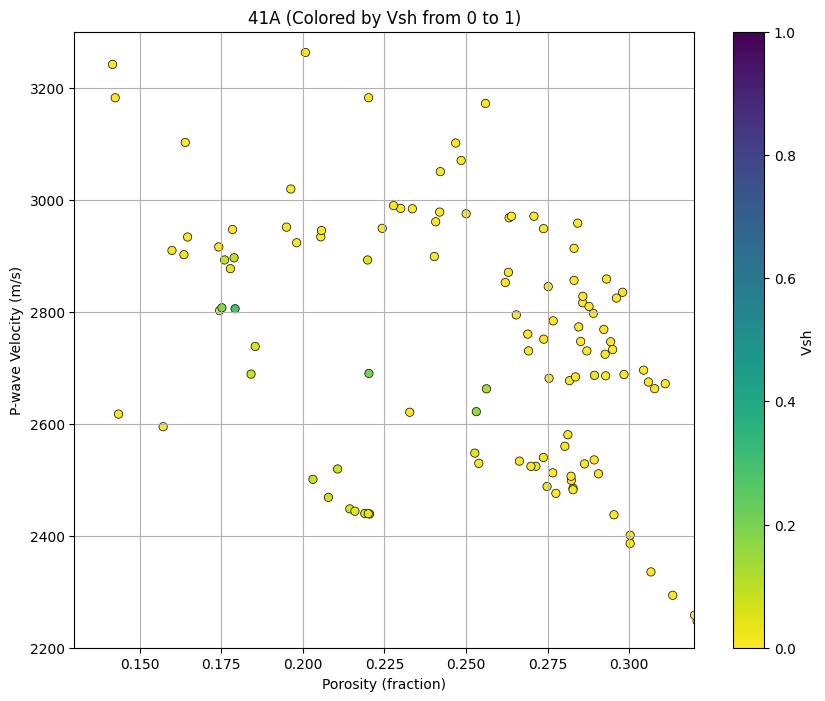

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Set the depth range
a1 = 1740.740232  # lower depth limit
b1 = 1770.619776  # upper depth limit

# Create a mask for the depth range
mask = (depths >= a1) & (depths <= b1)

# Define the color bar limits (Vsh range, for example, from 0 to 1)
vmin = 0.0
vmax = 1.0

# Plotting only the data within the specified depth range
plt.figure(figsize=(10, 8))
# Using the 'viridis_r' colormap with consistent color scale
sc = plt.scatter(porosity_density[mask], 1e6 * 0.3048 / log_DTC[mask], c=Vsh[mask], cmap='viridis_r', vmin=vmin, vmax=vmax, alpha=1, edgecolor='k', linewidth=0.5)

plt.xlabel('Porosity (fraction)')
plt.ylabel('P-wave Velocity (m/s)')

plt.xlim(0.13, 0.32)
plt.ylim(2200, 3300)



plt.title('41A (Colored by Vsh from 0 to 1)'.format(a1, b1))
cbar = plt.colorbar(sc)
cbar.set_label('Vsh ')
plt.grid(True)
plt.show()


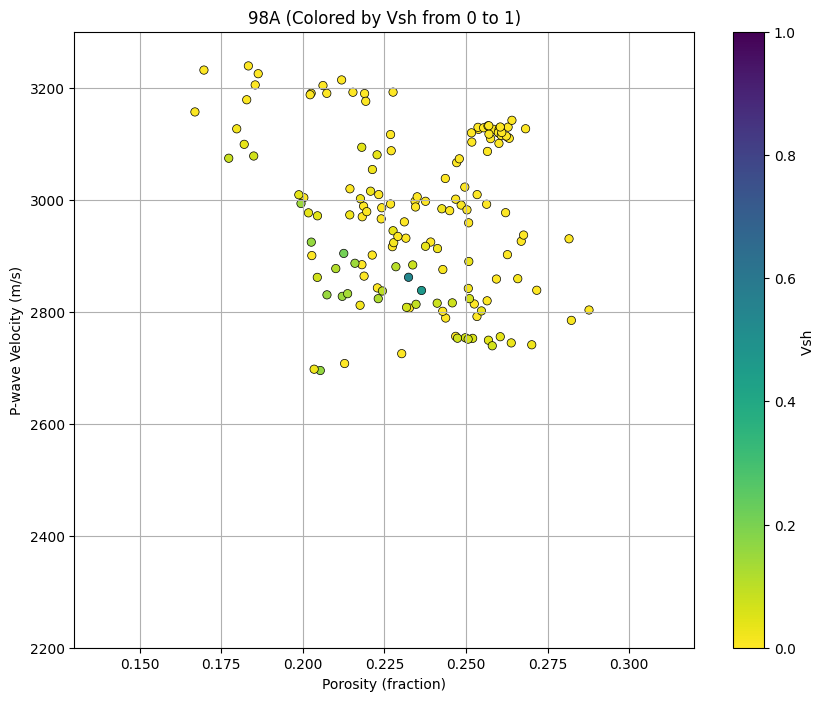

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Set the depth range
a1 = 1871.499432 # lower depth limit
b1 = 1911.18744

# Create a mask for the depth range
mask = (depths >= a1) & (depths <= b1)

# Define the color bar limits (Vsh range, for example, from 0 to 1)
vmin = 0.0
vmax = 1.0

# Plotting only the data within the specified depth range
plt.figure(figsize=(10, 8))
# Using the 'viridis_r' colormap with consistent color scale
sc = plt.scatter(porosity_density[mask], 1e6 * 0.3048 / log_DTC[mask], c=Vsh[mask], cmap='viridis_r', vmin=vmin, vmax=vmax, alpha=1, edgecolor='k', linewidth=0.5)

plt.xlabel('Porosity (fraction)')
plt.ylabel('P-wave Velocity (m/s)')

plt.xlim(0.13, 0.32)
plt.ylim(2200, 3300)


plt.title('98A (Colored by Vsh from 0 to 1)'.format(a1, b1))
cbar = plt.colorbar(sc)
cbar.set_label('Vsh ')
plt.grid(True)
plt.show()
